# 3D Time/Frequency/Phase Representation of Audio for Speech Recognition.

I recently participated in a <a href=https://www.kaggle.com/c/tensorflow-speech-recognition-challenge> speech recognition </a> kaggle competition. Although I didn't come close to the top of the leaderboard (238th place with 87% accuracy vs 91% accuracy for the winners) I learned quite a bit about handling audio data and had a lot of fun. One of the more novel things I tried during the competition was to spatially encode the phase information in the audio and pass the results into a 3D CNN.

A common pre-processing step in speech recognition is to turn the 1D audio into a 2D <a href="https://en.wikipedia.org/wiki/Spectrogram">spectrogram</a>. The spectrogram the volume of the audio as a function of time and at a particular frequency. Spectrograms are a great way of summarizing the important information in an audio clip in a way that makes it accessible visually. Here is a spectrogram of an utterance of the word "marvin".

![marvin_specgram](../images/marvin_specgram.jpg)

<!-- TEASER_END -->

Although the plot of the audio trace is interesting it is nothing compared to the richness of the visual information available from the spectrogram. Since spectrograms are not only beautiful but are also intuitively interpretable it is no wonder that they would be a popular choice for preprocessing audio data before digesting with a neural network.

However not all information in the input audio makes it into the output spectrogram. To find the volume at a particular time and frequency we first decompose the audio into a sum of windowed sinusoids using a short time Fourier transform (STFT). The STFT gives us a set of complex numbers with the magnitude of those numbers represnting a magnitude of the associated sinusoid and the angle of the complex number representing its phase. To get the spectrogram you want just the volume information which is the magnitude of the STFT and you throw away the phase information entirely.

If you look at the phase information corresponding to the same audio sample as above it is easy to see why the phase is usually just thrown away.

![phase_angle_example](../images/marvin_phase_angle.jpg)

You might be able to see some weak signs of structure in the raw phase data but you could be forgiven for assuming that it was all just structureless random noise. The fact that we can do good word classification without incorporating the phase information seems to back this idea up. However if the phase information really were just random noise which carried no additional information then any 2 sound clips which share the same spectrogram should sound the same to our ear. Lets listen to the example sound clip.

In [1]:
import os
import numpy as np
import scipy.signal

import IPython.display as ipd
import tf_speech_recognition as tsr #local python library written for the competition

Using TensorFlow backend.


In [2]:
example_file = os.path.join(tsr.data_dir, "raw", "train", "audio", 'marvin/fda46b78_nohash_0.wav')
audio = tsr.read_wav(example_file)
ipd.Audio(audio, rate=16000)

Nice and understandable and human sounding. Now lets see what happens to the audio when we replace the phase information with random phases. We simply generate white noise in the time domain and then apply the same STFT to both noise and voice audio. But at reconstruction time we take the phase information from the noise and the magnitude information from the noise. The resulting audio sample will have exactly the same spectrogram as the original audio but truely randomized phases. Will it sound the same?

In [3]:
stft = scipy.signal.stft(audio)[2]
stft_mag = np.abs(stft)

noise_stft = scipy.signal.stft(np.random.normal(size=audio.shape))[2]
random_phase = noise_stft/(np.abs(noise_stft)+1e-5)
phase_randomized_audio = scipy.signal.istft(stft_mag*random_phase)[1]
ipd.Audio(phase_randomized_audio, rate=16000)

The sound clip is still understandable but now the speaker has seemingly been assimilated by the borg. Instead of sounding like a single coherent voice it suddenly sounds like a cacophony of many nearly coherent voices but all with tiny random offsets. Although the second clip is certainly still understandable it no longer sounds much like a normal human voice. That may be enough to show that that the phases are not random but it isn't enough to show that the phase information adds anything above and beyond the regular spectrogram when it comes to speech recognition. After all we can still make out what the word is supposed to be just fine even with totally random phases.

A good way to address whether or not the phase information adds anything to the classification problem is to try and incorporate it into a machine learning system and see if we can get improved classification performance using phase information than without it.

The first problem we have to solve is how to best process the audio to make the phase information available to our models. We can of course simply feed the raw audio in to our neural network but then we lose all the nice aspects of using spectrogram inputs. We can simply directly feed the phase in radians in to the network as an extra channel along with the magnitude but as we saw above the phase information as a raw phase angle doesn't have any apparent image like structure, it just looks like a random mess. 

An interesting idea is to try and map the audio into a 3D time/frequency/phase space just in the same way that audio is commonly mapped to a 2D time/frequency space. Just like frequency and time there is a natural sense in which one phase is closer to another, $\pi$ radians is close to $7/8 \pi$ radians and far from 0 radians. We can somewhat naturally then encode the phase information as an index along the third dimension of a 3D tensor in the same way that the STFT encodes frequency by an index along the second dimension of a 2D tensor. We can either then treat the resulting phase information as extra channels in a 2D input image to a 2D CNN or double down on the spatial representation and feed the result as a 1 channel 3D "image" into a 3D CNN. The 3D CNN idea is too juicy to ignore and so that is what I decided to do. I also experimented with passing the phase information as channels into a 2D CNN and the results seemed comparable but the idea just isn't as much fun. Unfortunately the 3D CNN is much more memory greedy and so takes longer to train and requires that smaller batch sizes be used.

No implementation that I attempted 

## Base TF Phased Spectrogram Code.

Here is some base code for processing the audio inputs and generating a "phased" spectrogram in which the magntidue of the spectrogram is modulated by how closely aligned it is to a target phase angle, one phase angle per slice in a 3D output tensor.

The amount which the spectrogram gets attenuated is determined by ak "phase_kernel" which takes as an input the euclidean distance between the location on the unit circle of the target phase and the central phase of the corresponding index in the 3D tensor. 

The reason for taking the linear distance in the 2D plane is to handle the fact that 0.9$\pi$ radians and $3.1\pi$ radians are equally close to $\pi$ radians since any difference of $2\pi$ radians is the same as a difference of 0. Ideally we would take a "distance" between phase angles directly in radians since that would cause a minimum of distortion but I can't think of a way to express that in TensorFlow code that will be totally free of jump discontinuities. Just so long as our phase kernel drops off fast enough the 2D euclidean distance should be a servicable approximation to the phase difference in radians. 

In [4]:
import matplotlib.pyplot as plt
import time, copy

import keras
import keras.backend as K
import tensorflow as tf

%matplotlib inline

In [5]:
input_length = 16000
target_length = 16384

sound_in = keras.layers.Input(shape=(target_length,), name="audio")

In [6]:
def make_spectrogram_function(
    frame_length, 
    frame_step,
    magnitude_activation=lambda x: tf.log(1+x),
    fft_length=None
):
    "helper function for making spectrogram Lambda layers in keras"
    def _spectrogram(x):
        stft = tf.contrib.signal.stft(
            x,
            frame_length=frame_length,
            frame_step=frame_step,
            fft_length=fft_length,
            pad_end=True,
        )
        mag = tf.abs(stft)
        return magnitude_activation(mag)        
    return _spectrogram

def make_phased_spectrogram_function(
    frame_length, 
    frame_step, 
    phase_kernel,
    fft_length=None,
    phase_mag_damp=1e-5,
    phase_resolution=8,
    phase_only=False,
    magnitude_activation=lambda x: tf.log(1.0+x),
):
    "helper function for making phased spectrogram Lambda layers in keras"
    def _spectrogram(x):
        stft = tf.contrib.signal.stft(
            x,
            frame_length=frame_length,
            frame_step=frame_step,
            fft_length=fft_length,
            pad_end=True,
        )
        mag = tf.abs(stft)
        real_part = tf.real(stft)
        imag_part = tf.imag(stft)
        xpos = real_part/(mag+phase_mag_damp)
        ypos = imag_part/(mag+phase_mag_damp)
        
        #generate phase_resolution equally spaced angles
        phi_knots = np.linspace(0, 2*np.pi, phase_resolution+1)[:-1]
        x_knots = np.cos(phi_knots)
        y_knots = np.sin(phi_knots)
        
        mag_act = magnitude_activation(mag)
        
        if phase_only:
            activations = []
        else:
            activations = [mag_act]
        for i in range(phase_resolution):
            dist_sq = (xpos-x_knots[i])**2 + (ypos-y_knots[i])**2
            phase_act = phase_kernel(dist_sq)
            if phase_only:
                act = mag_act*phase_act
            activations.append(act)
        
        activations = tf.stack(activations, axis=3)
        
        return activations        
    return _spectrogram

## Picking a phase kernel

To encode the phase information spatially we need to pick both a number of phase slices to use and how rapidly the activation of a particular phase slice should fall off as the phase of the input spectrogram becomes more distant. Since we are using the 2D euclidean distance as an approximation it makes sense to simply plot up the value of a proposed kernel in 2D. We want to pick enough points on the unit circle so that we can get a good approximation to the phase angle but not so many that we will run out of memory resources when building our network. We also need to make sure that the kernel function we choose drops off fast enough so that the euclidean distance approximation is still roughly valid (we don't want $-\pi$ and $\pi$ to start both simultaneously having high non-zero activations) but we don't want it to drop off so fast that a phase half way in between two slices in our phase grid wont significantly activate its two neighboring slices. The ever ubiquitous Gaussian kernel seems like as good as any to use and I tuned the kernel width and the number of phase slices by tweaking the look of the plot below. The larger the number of phase slices the better resolution in phase but also the more redundant our representation and the less well the 2D euclidean distance between adjacent phases approximates the phase difference in radians.

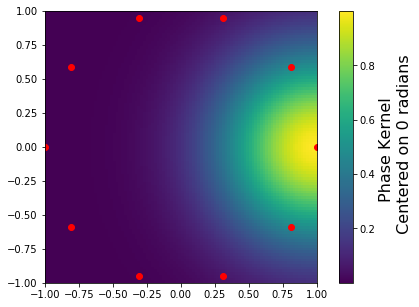

In [7]:
phase_resolution = 10
phase_sigma = 0.8*2*np.pi/phase_resolution

xc, yc = np.meshgrid(np.linspace(-1.0, 1.0, 100), np.linspace(-1.0, 1.0, 100))
target_x, target_y = 1, 0
theta_grid = np.linspace(0, 2*np.pi, phase_resolution+1)[:-1]
radii_squared = (xc-target_x)**2 + (yc-target_y)**2
phase_similarity = np.exp(-0.5*radii_squared/phase_sigma**2)

fig, ax = plt.subplots(figsize=(8, 5))

kernel_value_img = ax.imshow(phase_similarity, extent=(-1, 1, -1, 1))
cbar = plt.colorbar(kernel_value_img)
cbar.set_label("Phase Kernel \n Centered on 0 radians", fontsize=16)
ax.plot(np.cos(theta_grid), np.sin(theta_grid), linestyle="none", marker="o", color="r")

Now to load in some helpers for data loading and batching from a python helper module I wrote for the speech competition.

In [8]:
command_words = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
command_encoder = tsr.preprocessing.LimitedVocabularyEncoder(
    vocabulary=command_words,
    encoding_type="onehot",
)

preprocessor = tsr.SoundPreprocessor(
    input_transforms={"audio":lambda x, y: x},
    output_transforms={
        "command_probs":lambda x, y: command_encoder.encode(x["word"]),
    },
    input_length=input_length,
    target_length=target_length,
    downsampling_rate=1,
    t_shift_max=0,
    silence_fraction=0.1,
    additive_bg_fraction=0.3,
    bg_mag_range=(0.01, 0.1),
    stretch_fraction=0,
    stretch_range=None,
    stretch_center=0.5,
    repitching_fraction=0,
    repitching_range=None,
    relabel_fraction=0.0,
    bg_noise_samples=tsr.get_background_noise_samples(),
    mean_subtract=True,
    norm_type="rms",
    norm_damp=1e-4,
)

load_batch = tsr.data_loading.simple_sound_batch_loader

train_labels = tsr.get_labels_df("train")

train_loading_kwargs = dict(
    labels_df=train_labels,
    preprocessor=preprocessor,
    augment=True,
    data_directory=os.path.join(tsr.data_dir, "raw", "train", "audio"),
    forcing_kwargs={},
)

/home/tim/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


## Phased Spectrogram Visualizations

Because these phased spectrograms are 3D tensors they are significantly more difficult to visualize than regular spectrograms which you can just visualize as images. The easiest way to visualize the 3D tensor is to simply take slices and look at them one at a time. But it is difficult to get a sense of the global structure that way. Chain the slice visualizations together and you have a movie. 

With a little work we can make a nice animation in matplotlib which takes a 3D array and animates a movie of slices through it.

In [9]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rc('animation', html='html5')

class SlicingAnimation():
    
    def __init__(
        self,
        data,
        animation_axis,
        reduction_axis,
        axis_labels,
        extents,
        vmin=None,
        vmax=None,
        reducer=np.mean,
        figsize=(10, 6),
    ):
        assert reduction_axis != animation_axis
        left_over_axis ,= list(set(range(3)) - set([animation_axis, reduction_axis]))
        
        #permute the input data so we won't have to do any reindexing later
        axis_order = [animation_axis, reduction_axis, left_over_axis]
        self.axis_order = axis_order
        self.axis_labels = [axis_labels[ao] for ao in axis_order]
        self.extents = [extents[ao] for ao in axis_order]
        data = data.transpose(axis_order)
        
        #extract a reduced 2D form of the input data to aid with orienting ourselves
        reduction_axis = axis_order[reduction_axis]
        self.reduced_approx = reducer(data, axis=1)
        
        self.data = data
        
        if vmin is None:
            vmin = np.min(data)
        self.vmin = vmin
        if vmax is None:
            vmax = np.max(data)
        self.vmax = vmax
        
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        self.fig = fig
        self.axes = axes
    
    def plot_init(self):
        im_kwargs = {
            "vmin":self.vmin,
            "vmax":self.vmax,
            "aspect":"auto",
            "origin":"lower",
        }
        self.axes[0].set_xlabel(self.axis_labels[0])
        self.axes[0].set_ylabel(self.axis_labels[2])
        self.axes[1].set_xlabel(self.axis_labels[2])
        self.axes[1].set_ylabel(self.axis_labels[1])
        
        extent = []
        extent.extend(self.extents[0])
        extent.extend(self.extents[1])
        static_im = self.axes[0].imshow(
            self.reduced_approx.transpose(),
            extent=extent,
            **im_kwargs
        )
        extent = []
        extent.extend(self.extents[2])
        extent.extend(self.extents[1])
        changing_im = self.axes[1].imshow(
            self.data[0],
            extent=extent,
            **im_kwargs,
        )
        
        self.temporal_indicator = self.axes[0].plot([], [], alpha=0.8, c="r")[0]
        self.static_im = static_im
        self.changing_im = changing_im
        return [static_im, changing_im, self.temporal_indicator]
    
    def update(self, frame):
        self.changing_im.set_data(self.data[frame])
        delta = self.extents[0][1]-self.extents[0][0]
        ind_coord = self.extents[0][0] + frame/len(self.data) * delta
        span = self.axes[0].get_ylim()
        self.temporal_indicator.set_data([ind_coord, ind_coord], span)
        return [self.static_im, self.changing_im, self.temporal_indicator]
    
    def get_anim(self):
        ani = FuncAnimation(
            self.fig, 
            self.update, 
            frames=len(self.data),
            init_func=self.plot_init, 
            blit=True,
        )
        return ani

Now we have everything we need to visualize the phase structure in a way which hopefully will give us more insight than simply displaying a heat map of phase angle.

In [10]:
time_resolution = 256
size_ratio = int(target_length/time_resolution)
phased_spectrogram = keras.layers.Lambda(
    make_phased_spectrogram_function(
        frame_length=4*size_ratio, 
        frame_step=size_ratio,
        phase_resolution=phase_resolution,
        phase_mag_damp=1e-5,
        phase_kernel = lambda x: tf.exp(-0.5*x/phase_sigma**2),
        phase_only=True,
    )
)(sound_in)

phased_specgram_model = keras.models.Model(sound_in, phased_spectrogram)

During training it will be desirable to add extra noise and/or stretch and repitch the input sounds but for the moment all that noise is just going to make it more difficult to understand the structure in our samples. So we want to turn augmentation off for these visualizations.

In [11]:
train_loading_kwargs_no_aug = copy.copy(train_loading_kwargs)
train_loading_kwargs_no_aug["augment"] = False

I've picked an example of the word "sheila" and cropped the time dimension down so that we don't spend much time looking at the silence before or after. If you animate the time axis and display frequency/phase slices for each time step you get the following. In order to save on filesize of this notebook I have saved the animation out to file instead of displaying it inline. The %%capture magic in the cell below is to suppress the usual inline output so that we don't see two versions of the same file. However you can embed the animation directly in the notebook without saving it out by removing the %%capture line at the top of the cell and ending the cell simply with phase_anim.get_anim(). 

In [12]:
%%capture
word = "sheila"
example_file = train_labels.index[train_labels.word.values == word][4]
example_batch = load_batch([example_file], **train_loading_kwargs_no_aug)
spec_out = phased_specgram_model.predict(example_batch[0])[0]

print("word=", word)

t_keep = 0.7
cur_dat = spec_out[:int(len(spec_out)*t_keep)]
vmax = np.percentile(cur_dat, 99)
extents = [
    (0, 1000*t_keep),   
    (0, 8000),
    (0, 2*np.pi*(1-1.0/phase_resolution)), 
]
phase_anim = SlicingAnimation(
    data=cur_dat,
    animation_axis=0,
    reduction_axis=2,
    axis_labels=["time", "frequency", "phase"],
    extents=extents,
    vmin=0,
    vmax=vmax,
    reducer=np.max,
)
mpl_anim = phase_anim.get_anim()
mpl_anim.save("../files/videos/sheila_phase_animation.mp4")

In [26]:
%%HTML
<video width="640" height="480" controls>
  <source src="../videos/sheila_phase_animation.mp4" type="video/mp4">
</video>

Something you might notice is that the phases tend to form little groups which move somewhat coherently over a small band of frequencies. This behavior is particularly pronounced in the regions of the word which correspond to the vowel sounds. I think these coherent phase patterns are due to resonances of the vocal tract of the speaker (also apparently sometimes called <a href=https://en.wikipedia.org/wiki/Formant> formants </a>). 

## 3D Convolutional Neural Net

Even though this representation of the phase information certainly makes it more accessible than a raw phase heatmap it still is difficult to grasp completely. Fortunately for us we don't really need to be able to clearly see the structure in our data in order for a neural network to exploit it. Now that we have transformed the phase information into a spatial dimension we can process it like volumetric data by passing it in to a 3D CNN. 

The phase dimension is different than the time and frequency dimensions in that it wraps around on itself. The 0'th slice is close to the n-1'th slice. In order to give the neural network access to the adjacent phase slices even at the edges of the phase grid we add Lambda layers which concatenate the last theta layer to the beginning of the phase stack and the first theta layer to the end. If we then use convolutions with padding="valid" then we will recover the same result we would have ahieved if the convolutional kernel wrapped around the theta dimension.

I have tinkered with a number of fairly different architectures. Most of the architectures I have tried peter out around an F1 score averaged over words of around 0.93-0.94. This is the generally same sort of performance that I get from 2D CNN models in which the phase information is thrown away. That seems to indicate that either the phase information isn't adding much or that the way I have coded up the network isn't able to take advantage of it. However all of my 2D CNN models benefit from a greatly increased batch size which is something that I can't do as easily for the 3D CNN models since I run out of memory for even modestly sized batches. The fact that the 3D models do so well with a maximum batch size of 32 might be an indication that they could perform better than the 2D models if only I could train them effectively.

In [11]:
def concat_theta_layer(activation):
    #n_theta = activation.shape[3]
    return K.concatenate([activation[:, :, :, :1], activation, activation[:, :, :, -1:]], axis=3)

def theta_concat_output_shape(input_shape):
    nb, nr, nz, nt, nf = input_shape
    return (nb, nr, nz, nt+2, nf)

from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import MaxPooling1D, MaxPooling2D, MaxPooling3D
from keras.layers import LeakyReLU, concatenate

def make_conv(
        x,
        n_filters,
        kernel_size,
        conv_strides,
        leak,
        pool_size,
        pool_strides,
        conv_kwargs=None,
):
    n_dim = len(x.shape)
    if n_dim == 3:
        conv = Conv1D
        pool = MaxPooling1D
    elif n_dim == 4:
        conv = Conv2D
        pool = MaxPooling2D
    elif n_dim == 5:
        conv = Conv3D
        pool = MaxPooling3D
    else:
        raise ValueError()
    
    default_conv_kwargs = {
        "padding":"same",
    }
    
    if conv_kwargs is None:
        conv_kwargs={}
    default_conv_kwargs.update(conv_kwargs)
    x = conv(
        n_filters, 
        kernel_size=kernel_size,
        strides=conv_strides,
        **default_conv_kwargs
    )(x)
    if not pool_size is None:
        x = pool(
            pool_size=pool_size,
            strides=pool_strides,
            padding="same",
        )(x)
    else:
        assert pool_strides is None
    x = LeakyReLU(alpha=leak)(x)
    return x

In [18]:
x = phased_spectrogram

#add a channels dimension to the spectrogram data
x = keras.layers.Lambda(lambda x:tf.expand_dims(x, axis=4))(x)

x=keras.layers.Lambda(concat_theta_layer, output_shape=theta_concat_output_shape)(x)
x = make_conv(x, 16,  (3, 3, 3),  (2, 2, 1), 0.2, None, None, conv_kwargs={"padding":"valid"})
x=keras.layers.Lambda(concat_theta_layer, output_shape=theta_concat_output_shape)(x)
x = make_conv(x, 32,  (3, 3, 3),  (2, 2, 1), 0.2, None, None, conv_kwargs={"padding":"valid"})
x=keras.layers.Lambda(concat_theta_layer, output_shape=theta_concat_output_shape)(x)
x = make_conv(x, 64,  (3, 3, 3),  1, 0.2, None, None, conv_kwargs={"padding":"valid"})
x=keras.layers.Lambda(concat_theta_layer, output_shape=theta_concat_output_shape)(x)
x = make_conv(x, 128,  (3, 3, 3),  1, 0.2, None, None, conv_kwargs={"padding":"valid"})

#leave the concatenated theta dimensions padding="same"
x=keras.layers.Lambda(concat_theta_layer, output_shape=theta_concat_output_shape)(x)
x = make_conv(x, 256,  (3, 3, 3),  1, 0.2, None, None)

#reduce the size of the phase dimension by max pooling
x = make_conv(x, 128,  1,  1, 0.2, (1, 3, 4), (1, 3, 4))

#stack the phase and frequency dimensions together as extra channels
reduction_shape = (int(x.shape[1]), int(x.shape[2])*int(x.shape[3])*int(x.shape[4]))
x = keras.layers.Reshape(reduction_shape)(x)
#now the convolutions will be 1D

#collapse the channels down to a manageable number again
#x = make_conv(x, 128, 1, 1, 0.2, None, None)
x = make_conv(x, 32, 3, 1, 0.2, None, None)
timewise_features = x

dense_predictor = keras.layers.Dense(12)(keras.layers.Flatten()(timewise_features))

time_indep_features = keras.layers.GlobalMaxPooling1D()(timewise_features)
max_pooled_predictor = keras.layers.Dense(12)(time_indep_features)


x = keras.layers.Add()([dense_predictor, max_pooled_predictor])
x = keras.layers.Activation("softmax", name="command_probs")(x)

command_probs = x

In [20]:
model = keras.models.Model(sound_in, command_probs)

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio (InputLayer)              (None, 16384)        0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 129, 10) 0           audio[0][0]                      
__________________________________________________________________________________________________
lambda_14 (Lambda)              (None, 256, 129, 10, 0           lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, 256, 129, 12, 0           lambda_14[0][0]                  
__________________________________________________________________________________________________
conv3d_13 

In [22]:
def damped_log_loss(y_true, y_pred):
    damp_param = 0.0001
    clipped = (y_pred+damp_param)/(1.0+2.0*damp_param)
    costs = -1.0*(y_true*K.log(clipped) + (1.0-y_true)*K.log(1.0-clipped))
    return K.mean(costs)

In [23]:
optimizer = "adadelta"
model.compile(loss=damped_log_loss, optimizer=optimizer)

In [24]:
dev_labels = tsr.get_labels_df("dev")

dev_loading_kwargs = dict(
    labels_df=dev_labels,
    preprocessor=preprocessor,
    augment=False,
    data_directory=os.path.join(tsr.data_dir, "raw", "train", "audio"),
    forcing_kwargs={},
)

In [25]:
import sklearn.metrics

train_losses = []
model_quality_results = []

def do_training_iteration(): 
    train_hashes = train_batcher.make_batch(batch_size)
    xi, yi, aug_dict = load_batch(
        train_hashes, 
        **train_loading_kwargs,
    )
    ctime = time.time()
    yres = model.train_on_batch(xi, yi)
    train_losses.append(yres)

batch_size = 32
batches_per_epoch = len(train_labels)//batch_size + 1

train_batcher = tsr.data_loading.BalancedBatcher([train_labels.index,])

print("beginning training")

for epoch_idx in range(10):
    stime = time.time()
        
    print("\n epoch", epoch_idx+1)
    for iter_idx in range(batches_per_epoch):
        do_training_iteration()
        if (iter_idx % 50) == 0:
            print("{:4.5f} ".format(np.mean(train_losses[-50:])), end="")
    print("\n")
    etime = time.time()
    print("{:4.2f} minutes per epoch".format((etime-stime)/60.0))
    mq_res = tsr.evaluate_command_model_quality(
            eval_labels=dev_labels,
            command_model=model,
            metrics={"f1":lambda x, y: sklearn.metrics.f1_score(x, y>0.5)},
            batch_loader=load_batch,
            batch_size=batch_size,
            loading_kwargs=dev_loading_kwargs,
    )
    print(mq_res)
    avg_mq = {metric_name:np.mean(mq_res[metric_name]) for metric_name in mq_res}
    print(avg_mq)


beginning training

 epoch 1
0.28770 0.21902 0.17688 0.17231 0.14983 0.14786 0.13679 0.12461 0.11239 0.10515 0.09558 0.09674 0.09450 0.08528 0.07854 0.07652 0.07930 0.07123 0.06363 0.06660 0.05967 0.06002 0.05993 0.05732 0.05041 0.05183 0.05647 0.04738 0.04740 0.04375 0.04720 0.04538 

17.87 minutes per epoch
{'f1': [0.90243902439024382, 0.79078694817658346, 0.83089770354906045, 0.8125, 0.82823529411764707, 0.87688984881209509, 0.80266075388026625, 0.780287474332649, 0.90109890109890112, 0.76039603960396041, 0.9440276976341605]}
{'f1': 0.83911088050868798}

 epoch 2
0.04075 0.03771 0.04208 0.04154 0.04150 0.03635 0.03854 0.03568 0.03651 0.03064 0.03522 0.03248 0.03725 0.03486 0.03090 0.03479 0.03496 0.03141 0.02840 0.02984 0.03260 0.03188 0.03131 0.02726 0.02604 0.03027 0.02663 0.02936 0.02565 0.02692 0.02270 0.02711 

18.20 minutes per epoch
{'f1': [0.9158878504672896, 0.85211267605633811, 0.89494163424124507, 0.90258449304174948, 0.92693110647181631, 0.92213114754098358, 0.8668076109

## Final Thoughts

Wrapping the phase convolutions around in the phase dimension so that the spots close to 0 phase interact with those close to 2$\pi$ seemed like a good idea but it adds significant computational overhead since the entire tensor needs to get copied between the input and output of each layer. Also because the inputs can only ever have just one phase the phase dimension adds a huge amount of redundancy. If we have 10 phase slices then at most only around 1/10th of our numbers will be non-zero. 

Although the use of the 3D CNN is fun the time/frequency/phase structure of the speech data doesn't look enough like volumetric data to justify a using 3D CNN. The memory and computation constraints all go through the roof without much apparent benefit. I can train up a 1D CNN model with quality comparable to my 3D CNN in less than a 2% of the training time. It should be noted however that likely one of the places where incorporating the phase information would have one of the biggest advantages is in telling the difference between noise and speech. In speech the phases aren't random at all but in pure noise even noise with strange power spectra like brown or blue noise the phase information is usually still totally random. There is no pure noise in the held out dev set and so the way we are evaluating the 3D CNN does not include in a meaningful way the ability of the CNN to tell the difference between noise and speech.

Phase information really may not be important for distinguishing words from each other but it clearly is still important to how we perceive sounds as humans. Because of the large amount of redundancy involved, transforming phase into position in a 3D tensor is probably not the right way to encode the phase information. Feeding a raw phase angle into a 2D convolution doesn't seem like a good way to do it either however since the value of that convolution would be dramatically changed by shifting a phase from -$\pi$ to $\pi$ when such a phase change represents absolutely no change in the corresponding efffective phase information. That problem could possibly be somewhat alleviated by a data augmentation strategy where we randomly add a global phase shift of between 0 and 2$\pi$ and then normalize back to the -$\pi$ to $\pi$ range but there has to be a more elegant way.